### 1. Import libraries

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
from scipy.special import expit, logit
from scipy.stats import norm, chi2
import scipy.stats as stats
from itertools import combinations
import matplotlib.pyplot as plt
import json

### 2. Load data set

In [157]:
df = pd.read_json('/mnt/d/PYDataScience/HIV_TXP_SR/data/supp.json')
# Print the shape of the DataFrame
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Print the column names
print(df.columns)

Number of rows: 49
Number of columns: 191
Index(['study_id', 'author', 'year_of_publication', 'country_of_study',
       'study_type', 'sample_size_(hiv_seropositive_only)', 'intervention',
       'outcome', 'conclusion', 'hiv_negative_samples',
       ...
       'graft_rejection_>=_5_years', 'infection_1_year',
       'hazard_ratio_patient_survival_1_year',
       'hazard_ratio_patient_survival_3_years',
       'hazard_ratio_patient_survival_>=_5_years',
       'hazard_ratio_graft_survival_1_year',
       'hazard_ratio_graft_survival_3_years',
       'hazard_ratio_graft_survival_>=_5_years',
       'hazard_ratio_graft_rejection_1_year',
       'hazard_ratio_graft_rejection_>=_5_years'],
      dtype='object', length=191)


### 3. Publication bias with funnel plot, Egger's test and Begg's Rank correlation test

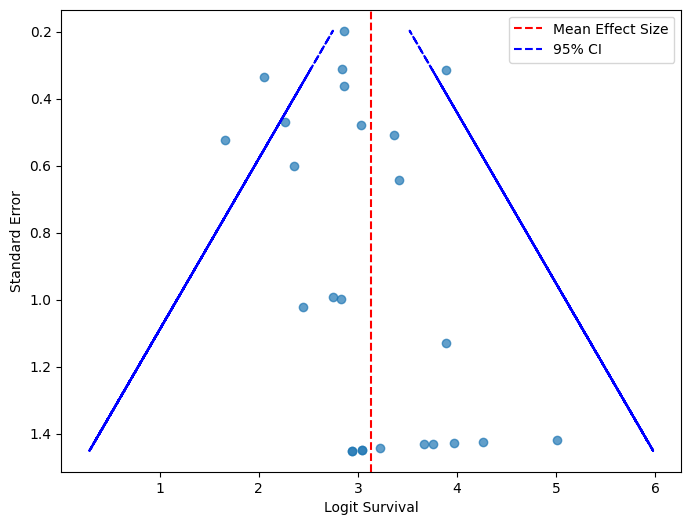

Egger's Regression Test Results:
{'slope': 0.7381592067244035, 'intercept': 2.447712656984941, 'r_value': 0.4789095154270887, 'p_value': 0.015435071016707309, 'std_err': 0.282136990676479}
Begg's Rank Correlation Test Results:
{'tau': 0.2050423063942535, 'p_value': 0.15369754399032323}


In [4]:
# Creating a copy of the relevant columns
survival_data = df[["study_id", "1-year_patient_survival_(%)_hiv+", 
                    # "3-year_patient_survival_(%)_hiv+", ">=_5-year_patient_survival_(%)_hiv+"
                    ]].copy()

# Replacing "None" with NaN and ensuring the data is numeric
survival_data.replace("None", np.nan, inplace=True)
survival_data.iloc[:, 1:] = survival_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Initialize an empty list for effect sizes
effect_size = np.full(len(survival_data), np.nan)

# Apply selection criteria
for i in range(len(survival_data)):
    # if not pd.isna(survival_data.iloc[i, 3]):
    #     effect_size[i] = survival_data.iloc[i, 3]
    # elif not pd.isna(survival_data.iloc[i, 2]):
    #     effect_size[i] = survival_data.iloc[i, 2]
    if not pd.isna(survival_data.iloc[i, 1]):
        effect_size[i] = survival_data.iloc[i, 1]

effect_size = effect_size / 100
sample_size = df['sample_size_(hiv_seropositive_only)'].to_numpy()

# Adjust effect sizes slightly to avoid 0% and 100%
effect_size = np.clip(effect_size, 1 / (2 * sample_size), 1 - 1 / (2 * sample_size))

# Apply logit transformation
logit_effect_size = np.log(effect_size / (1 - effect_size))

# Calculate standard error after logit transformation
se_logit = np.sqrt(1 / (sample_size * effect_size) + 1 / (sample_size * (1 - effect_size)))

# Remove NaN values from both logit_effect_size and se_logit
mask = ~np.isnan(logit_effect_size) & ~np.isnan(se_logit)
logit_effect_size_filtered = logit_effect_size[mask]
se_logit_filtered = se_logit[mask]

# Funnel plot
# Calculating the overall mean effect size
mean_effect_size = np.mean(logit_effect_size_filtered)

# Create the funnel plot
plt.figure(figsize=(8, 6))
plt.scatter(logit_effect_size_filtered, se_logit_filtered, alpha=0.7)

# Adding the vertical line for the mean effect size
plt.axvline(mean_effect_size, color='red', linestyle='--', label='Mean Effect Size')

# Adding the diagonal lines representing 95% CI
upper_ci = mean_effect_size + 1.96 * se_logit_filtered
lower_ci = mean_effect_size - 1.96 * se_logit_filtered
plt.plot(mean_effect_size + se_logit_filtered * 1.96, se_logit_filtered, color='blue', linestyle='--', label='95% CI')
plt.plot(mean_effect_size - se_logit_filtered * 1.96, se_logit_filtered, color='blue', linestyle='--')

# Inverting the y-axis
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Logit Survival')
plt.ylabel('Standard Error')
plt.legend()

# Show the plot
plt.savefig('/mnt/d/pydatascience/hiv_txp_sr/results/publication_bias_funnel_1000.png', dpi=1000)
plt.show()

# Egger's Regression Test (using linregress)
slope, intercept, r_value, p_value, std_err = linregress(se_logit_filtered, logit_effect_size_filtered)
egger_test = {
    "slope": slope,
    "intercept": intercept,
    "r_value": r_value,
    "p_value": p_value,
    "std_err": std_err
}
print("Egger's Regression Test Results:")
print(egger_test)

# Begg's Rank Correlation Test (approximation using Spearman correlation)
# Calculating Begg's rank correlation test
begg_tau, begg_p_value = stats.kendalltau(logit_effect_size_filtered, se_logit_filtered)
# begg_slope, begg_intercept, begg_r_value, begg_p_value, begg_std_err = linregress(logit_effect_size_filtered, np.arange(len(logit_effect_size_filtered)))
begg_test = {
    "tau": begg_tau,
    "p_value": begg_p_value,
}
print("Begg's Rank Correlation Test Results:")
print(begg_test)

### 4. Meta-analysis of primary and secondary outcome

In [109]:
# Function to convert logit to proportion
def logit_to_proportion(logit_value):
    return expit(logit_value)  # expit is the inverse of logit

# Function to perform meta-analysis
def perform_meta_analysis(valid_data):
    # Avoid proportions of 0 and 1 by adding a small constant
    epsilon = 0.5 / np.min(valid_data['sample_size'])
    valid_data['proportion'] = np.clip(valid_data['proportion'], epsilon, 1 - epsilon)
    # Logit transformation of proportions
    valid_data['z'] = logit(valid_data['proportion'])
    
    # Variance of logit-transformed proportions
    valid_data['var_z'] = 1 / (np.array(valid_data['sample_size']) * valid_data['proportion'] * (1 - valid_data['proportion']))
    
    w = 1 / np.array(valid_data['var_z'])
    z_bar = np.sum(w * valid_data['z']) / np.sum(w)
    k = len(valid_data['z'])  
    Q = np.sum(w * (valid_data['z'] - z_bar)**2)
    
    # Calculating p-value for Q
    p_value_Q = 1 - stats.chi2.cdf(Q, k - 1)

    if Q == k - 1:
        I2 = 0
    else:
        I2 = max(0, ((Q - (k - 1)) / Q) * 100)

    denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
    tau2 = 0 if denominator == 0 else (Q - (k - 1)) / denominator
    tau2 = max(0, tau2)  # Ensure non-negativity
    w_RE = 1 / (np.array(valid_data['var_z']) + tau2)
    w_RE_sum = np.sum(w_RE)
    if w_RE_sum == 0:
        z_bar_RE = 0
        weights_percent = [0] * k
    else:
        z_bar_RE = np.sum(w_RE * valid_data['z']) / w_RE_sum
        weights_percent = (w_RE / w_RE_sum) * 100

    se_z_bar_RE = np.sqrt(1 / np.sum(w_RE)) if w_RE_sum != 0 else 0
    ci_z_bar_RE = (z_bar_RE - 1.96*se_z_bar_RE, z_bar_RE + 1.96*se_z_bar_RE)
    
    # Calculate overall effect Z-value and p-value
    Z_value = z_bar_RE / se_z_bar_RE
    p_value_Z = 2 * (1 - norm.cdf(np.abs(Z_value)))

    # Back Transformation to proportion scale
    proportion_bar_RE = expit(z_bar_RE)
    ci_proportion_bar_RE = (expit(ci_z_bar_RE[0]), expit(ci_z_bar_RE[1]))

    # Prepare DataFrame with study-specific results
    valid_data['effect_size'] = expit(valid_data['z'])
    valid_data['ci_lb'] = expit(valid_data['z'] - 1.96 * np.sqrt(valid_data['var_z']))
    valid_data['ci_ub'] = expit(valid_data['z'] + 1.96 * np.sqrt(valid_data['var_z']))
    valid_data['weight_percent'] = weights_percent

    # Create a DataFrame for the pooled result
    pooled_result = pd.DataFrame({
        'study_id': ['Pooled Estimate'],
        'sample_size': [np.sum(valid_data['sample_size'])],
        'effect_size': [proportion_bar_RE],
        'ci_lb': [ci_proportion_bar_RE[0]],
        'ci_ub': [ci_proportion_bar_RE[1]],
        'weight_percent': [np.sum(weights_percent)]
    })

    # Combine individual study results with the pooled result
    combined_results = pd.concat([valid_data[['study_id', 'sample_size', 'effect_size', 'ci_lb', 'ci_ub', 'weight_percent']], pooled_result])

    return proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z

def identify_heterogeneity_study(valid_data):
    """Identify the study that causes heterogeneity (I2) to exceed 40%."""
    Q = 0
    df = 0
    for i in range(len(valid_data)):
        subset = valid_data.iloc[:i+1]
        w = 1 / np.array(subset['var_z'])
        z_bar = np.sum(w * subset['z']) / np.sum(w)
        Q = np.sum(w * (subset['z'] - z_bar)**2)
        df = len(subset) - 1
        I2 = max(0, (Q - df) / Q * 100)
        if I2 > 75:
            return subset.iloc[-1]['study_id'], I2
    return None, I2

def recursive_exclusion(valid_data):
    excluded_studies = []
    while True:
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(valid_data)
        if I2 < 75:
            break
        study_name, I2 = identify_heterogeneity_study(valid_data)
        if study_name:
            excluded_studies.append(study_name)
            valid_data = valid_data[valid_data['study_id'] != study_name]
        else:
            break
    return valid_data, excluded_studies, proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z

# Select and rename columns
pt_survival_df = df[['sample_size_(hiv_seropositive_only)', 'study_id', 
                    '1-year_infection_incidence(100_pt-yr)_hiv+',
                    '3-year_infection_incidence(100_pt-yr)_hiv+',
                    '>=_5-year_infection_incidence(100_pt-yr)_hiv+']].copy()
pt_survival_df.columns = ['sample_size', 'study_id', '1_yr', '3_yr', '5_yr']

# Prepare data for 1-year survival meta-analysis
pt_survival_df['proportion'] = pt_survival_df['5_yr'] / 100
valid_data = pt_survival_df[['study_id', 'sample_size', 'proportion']].dropna()

# Perform the meta-analysis on the full data
full_proportion_bar_RE, full_ci_proportion_bar_RE, full_combined_results, full_I2, full_Q, full_p_value_Q, full_tau2, full_Z_value, full_p_value_Z = perform_meta_analysis(valid_data)

# Perform the recursive exclusion process
valid_data_excluded, excluded_studies, proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = recursive_exclusion(valid_data)

# Display the results
if excluded_studies:
    print(f"Studies causing high heterogeneity: {excluded_studies}")
    print("\nResults after excluding studies causing high heterogeneity:")
else:
    print("No studies caused high heterogeneity.")

print(f"Pooled 5-Year Survival Proportion: {proportion_bar_RE:.4f}")
print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
print(f"I²: {I2:.2f}%")
print(f"Q: {Q:.2f}")
print(f"p-value for Q: {p_value_Q:.4f}")
print(f"tau2: {tau2:.4f}")
print(f"Z: {Z_value:.2f}")
print(f"p-value for Z: {p_value_Z:.4f}")
# Display the combined results for each study and the pooled result
print(combined_results)

# Save both full and excluded results to JSON
full_combined_results_dict = full_combined_results.to_dict(orient='records')
combined_results_dict = combined_results.to_dict(orient='records')
summary_results = {
    "Full_Data": {
        "Pooled_Survival_Proportion": full_proportion_bar_RE,
        "95%_CI": full_ci_proportion_bar_RE,
        "I2": full_I2,
        "Q": full_Q,
        "p_value_for_Q": full_p_value_Q,
        "tau2": full_tau2,
        "Z": full_Z_value,
        "p_value_for_Z": full_p_value_Z,
        "combined_results": full_combined_results_dict
    },
    "Excluded_Data": {
        "Pooled_Survival_Proportion": proportion_bar_RE,
        "95%_CI": ci_proportion_bar_RE,
        "I2": I2,
        "Q": Q,
        "p_value_for_Q": p_value_Q,
        "tau2": tau2,
        "Z": Z_value,
        "p_value_for_Z": p_value_Z,
        "combined_results": combined_results_dict,
        "excluded_studies": excluded_studies
    }
}

summary_json_file_path = '/mnt/d/PYDataScience/HIV_TXP_SR/results/5_yr_infection.json'
with open(summary_json_file_path, 'w') as f:
    json.dump(summary_results, f, indent=4)

No studies caused high heterogeneity.
Pooled 5-Year Survival Proportion: 0.1820
95% CI: (0.1409, 0.2318)
I²: 23.00%
Q: 10.39
p-value for Q: 0.2387
tau2: 0.0481
Z: -9.67
p-value for Z: 0.0000
           study_id  sample_size  effect_size     ci_lb     ci_ub  \
1      Ailioaie2017           24     0.240000  0.110125  0.446234   
2        Alfano2018           19     0.263200  0.114003  0.497920   
11       Durand2021           75     0.150000  0.085612  0.249595   
16      Gathogo2014           35     0.120000  0.046890  0.274298   
29     Mazuecos2011           20     0.087500  0.019926  0.311414   
31     Mazuecos2013           36     0.069400  0.020206  0.212399   
43        Stock2010          150     0.167300  0.115715  0.235750   
45       Touzot2010           27     0.309400  0.165350  0.503273   
46       Vicari2016           53     0.225700  0.132760  0.356925   
0   Pooled Estimate          439     0.181957  0.140889  0.231767   

    weight_percent  
1         8.744380  
2      

#### Meta-analysis of the primary and secondary outcomes between HIV positive and negative patient groups post-renal transplantation:

In [127]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit
from scipy import stats
from scipy.stats import norm, chi2
import json
from itertools import combinations

# Function to perform meta-analysis
def perform_meta_analysis(valid_data):
    # Calculate log hazard ratios
    valid_data['log_hazard_ratio'] = np.log(valid_data['hazard_ratio'])
    
    # Variance of log hazard ratios
    valid_data['var_log_hazard_ratio'] = 1 / valid_data['sample_size']
    
    # Weights based on inverse variance
    w = 1 / np.array(valid_data['var_log_hazard_ratio'])
    z_bar = np.sum(w * valid_data['log_hazard_ratio']) / np.sum(w)
    k = len(valid_data['log_hazard_ratio'])
    Q = np.sum(w * (valid_data['log_hazard_ratio'] - z_bar)**2)
    
    # Calculating p-value for Q
    p_value_Q = 1 - chi2.cdf(Q, k - 1)

    if Q == k - 1:
        I2 = 0
    else:
        I2 = max(0, ((Q - (k - 1)) / Q) * 100)

    denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
    tau2 = 0 if denominator == 0 else (Q - (k - 1)) / denominator
    tau2 = max(0, tau2)  # Ensure non-negativity
    w_RE = 1 / (np.array(valid_data['var_log_hazard_ratio']) + tau2)
    w_RE_sum = np.sum(w_RE)
    if w_RE_sum == 0:
        z_bar_RE = 0
        weights_percent = [0] * k
    else:
        z_bar_RE = np.sum(w_RE * valid_data['log_hazard_ratio']) / w_RE_sum
        weights_percent = (w_RE / w_RE_sum) * 100

    se_z_bar_RE = np.sqrt(1 / np.sum(w_RE)) if w_RE_sum != 0 else 0
    ci_z_bar_RE = (z_bar_RE - 1.96*se_z_bar_RE, z_bar_RE + 1.96*se_z_bar_RE)

    # Calculate overall effect Z-value and p-value
    Z_value = z_bar_RE / se_z_bar_RE
    p_value_Z = 2 * (1 - norm.cdf(np.abs(Z_value)))

    # Back Transformation to hazard ratio scale
    hazard_ratio_bar_RE = np.exp(z_bar_RE)
    ci_hazard_ratio_bar_RE = (np.exp(ci_z_bar_RE[0]), np.exp(ci_z_bar_RE[1]))

    # Prepare DataFrame with study-specific results
    valid_data['effect_size'] = np.exp(valid_data['log_hazard_ratio'])
    valid_data['ci_lb'] = np.exp(valid_data['log_hazard_ratio'] - 1.96 * np.sqrt(valid_data['var_log_hazard_ratio']))
    valid_data['ci_ub'] = np.exp(valid_data['log_hazard_ratio'] + 1.96 * np.sqrt(valid_data['var_log_hazard_ratio']))
    valid_data['weight_percent'] = weights_percent

    # Create a DataFrame for the pooled result
    pooled_result = pd.DataFrame({
        'study_id': ['Pooled Estimate'],
        'sample_size': [np.sum(valid_data['sample_size'])],
        'effect_size': [hazard_ratio_bar_RE],
        'ci_lb': [ci_hazard_ratio_bar_RE[0]],
        'ci_ub': [ci_hazard_ratio_bar_RE[1]],
        'weight_percent': [np.sum(weights_percent)]
    })

    # Combine individual study results with the pooled result
    combined_results = pd.concat([valid_data[['study_id', 'sample_size', 'effect_size', 'ci_lb', 'ci_ub', 'weight_percent']], pooled_result])

    return hazard_ratio_bar_RE, ci_hazard_ratio_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z

def calculate_hazard_ratios(df, sample_size_col, sample_size_neg_col, study_id_col, group1_col, group2_col):
    # Select and filter the required columns
    selected_df = df[[study_id_col, sample_size_col, sample_size_neg_col, group1_col, group2_col]].dropna()
    
    # Convert survival probabilities from percentage to proportion
    selected_df[f'{group1_col}_prop'] = selected_df[group1_col] / 100
    selected_df[f'{group2_col}_prop'] = selected_df[group2_col] / 100

    # Convert survival probabilities to hazard rates
    selected_df[f'{group1_col}_hazard'] = -np.log(selected_df[f'{group1_col}_prop'])
    selected_df[f'{group2_col}_hazard'] = -np.log(selected_df[f'{group2_col}_prop'])

    # Avoid hazard rates of 0
    epsilon = 0.5 / np.min(selected_df[sample_size_col])
    selected_df[f'{group1_col}_hazard'] = np.where(selected_df[f'{group1_col}_hazard'] == 0, epsilon, selected_df[f'{group1_col}_hazard'])
    selected_df[f'{group2_col}_hazard'] = np.where(selected_df[f'{group2_col}_hazard'] == 0, epsilon, selected_df[f'{group2_col}_hazard'])

    # Calculate hazard ratios (HR)
    selected_df['hazard_ratio'] = selected_df[f'{group1_col}_hazard'] / selected_df[f'{group2_col}_hazard']
    selected_df['sample_size'] = selected_df[sample_size_col]
    
    return selected_df

def evaluate_study_contributions(valid_data):
    study_ids = valid_data['study_id'].unique()
    study_contributions = {study_id: [] for study_id in study_ids}

    for r in range(len(study_ids), 0, -1):
        for combo in combinations(study_ids, r):
            subset = valid_data[valid_data['study_id'].isin(combo)]
            _, _, _, I2, _, _, _, _, _ = perform_meta_analysis(subset)
            excluded_studies = set(study_ids) - set(combo)
            for study_id in excluded_studies:
                study_contributions[study_id].append(I2)

    study_contributions_diff = {study_id: np.mean(contributions) for study_id, contributions in study_contributions.items()}
    return study_contributions_diff

# Load and prepare the data
pt_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_patient_survival_(%)_hiv+', '1-year_patient_survival_(%)_hiv-', 
                        '3-year_patient_survival_(%)_hiv+', '3-year_patient_survival_(%)_hiv-', 
                        '>=_5-year_patient_survival_(%)_hiv+', '>=_5-year_patient_survival_(%)_hiv-']]

gf_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_graft_survival_(%)_hiv+', '1-year_graft_survival_(%)_hiv-', 
                        '3-year_graft_survival_(%)_hiv+', '3-year_graft_survival_(%)_hiv-', 
                        '>=_5-year_graft_survival_(%)_hiv+', '>=_5-year_graft_survival_(%)_hiv-']]

rj_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_cumulative_graft_rejection_(%)_hiv+', '1-year_cumulative_graft_rejection_(%)_hiv-', 
                        '3-year_cumulative_graft_rejection_(%)_hiv+', '3-year_cumulative_graft_rejection_(%)_hiv-', 
                        '>=_5-year_cumulative_graft_rejection_(%)_hiv+', '>=_5-year_cumulative_graft_rejection_(%)_hiv-']]

# Rename columns
pt_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
gf_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
rj_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']

# Select and filter data for 5-year cumulative graft rejection
result_df = calculate_hazard_ratios(rj_survival_hr_df, 'sample_size_pos', 'sample_size_neg', 'study_id', '5_yr_pos', '5_yr_neg')

# Perform the meta-analysis on the full data
full_hazard_ratio_bar_RE, full_ci_hazard_ratio_bar_RE, full_combined_results, full_I2, full_Q, full_p_value_Q, full_tau2, full_Z_value, full_p_value_Z = perform_meta_analysis(result_df)

# Evaluate study contributions to heterogeneity
study_contributions_diff = evaluate_study_contributions(result_df)

# Find the best combination of studies
best_combination, best_I2, best_combined_results, best_hazard_ratio_bar_RE, best_ci_hazard_ratio_bar_RE, best_Q, best_p_value_Q, best_tau2, best_Z_value, best_p_value_Z = find_best_combination(result_df)

# Display the results
if best_combination:
    print(f"Best combination of studies: {best_combination}")
    print("\nResults after excluding studies causing high heterogeneity:")
else:
    print("No combination of studies resulted in I² < 40%.")

print(f"Pooled 5-Year Cumulative Graft Rejection Hazard Ratio: {best_hazard_ratio_bar_RE:.4f}")
print(f"95% CI: ({best_ci_hazard_ratio_bar_RE[0]:.4f}, {best_ci_hazard_ratio_bar_RE[1]:.4f})")
print(f"I²: {best_I2:.2f}%")
print(f"Q: {best_Q:.2f}")
print(f"p-value for Q: {best_p_value_Q:.4f}")
print(f"tau2: {best_tau2:.4f}")
print(f"Z: {best_Z_value:.2f}")
print(f"p-value for Z: {best_p_value_Z:.4f}")
# Display the combined results for each study and the pooled result
print(best_combined_results)

# Save both full and best combination results to JSON
full_combined_results_dict = full_combined_results.to_dict(orient='records')
best_combined_results_dict = best_combined_results.to_dict(orient='records')
summary_results = {
    "Full_Data": {
        "Pooled_Hazard_Ratio": full_hazard_ratio_bar_RE,
        "95%_CI": full_ci_hazard_ratio_bar_RE,
        "I2": full_I2,
        "Q": full_Q,
        "p_value_for_Q": full_p_value_Q,
        "tau2": full_tau2,
        "Z": full_Z_value,
        "p_value_for_Z": full_p_value_Z,
        "combined_results": full_combined_results_dict
    },
    "Best_Combination_Data": {
        "Pooled_Hazard_Ratio": best_hazard_ratio_bar_RE,
        "95%_CI": best_ci_hazard_ratio_bar_RE,
        "I2": best_I2,
        "Q": best_Q,
        "p_value_for_Q": best_p_value_Q,
        "tau2": best_tau2,
        "Z": best_Z_value,
        "p_value_for_Z": best_p_value_Z,
        "combined_results": best_combined_results_dict,
        "best_combination": list(best_combination)
    },
    "Study_Contributions": study_contributions_diff
}

summary_json_file_path = '/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_rejection_hr.json'  # Specify your desired path and filename here
with open(summary_json_file_path, 'w') as f:
    json.dump(summary_results, f, indent=4)

Best combination of studies: ('Apewokin2018', 'Mazuecos2011', 'Vicari2016')

Results after excluding studies causing high heterogeneity:
Pooled 5-Year Cumulative Graft Rejection Hazard Ratio: 0.7077
95% CI: (0.5581, 0.8973)
I²: 65.01%
Q: 5.72
p-value for Q: 0.0574
tau2: 0.0279
Z: -2.85
p-value for Z: 0.0043
           study_id  sample_size  effect_size     ci_lb     ci_ub  \
4      Apewokin2018          605     0.820911  0.758035  0.889002   
29     Mazuecos2011           20     0.614278  0.396303  0.952145   
46       Vicari2016           53     0.609019  0.465272  0.797176   
0   Pooled Estimate          678     0.707661  0.558083  0.897328   

    weight_percent  
4        49.736105  
29       18.851783  
46       31.412112  
0       100.000000  


/tmp/ipykernel_3486433/3011228953.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['log_hazard_ratio'] = np.log(valid_data['hazard_ratio'])
/tmp/ipykernel_3486433/3011228953.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['var_log_hazard_ratio'] = 1 / valid_data['sample_size']
/tmp/ipykernel_3486433/3011228953.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

#### Heterogeneity analysis

/tmp/ipykernel_3486433/2924295744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['log_hazard_ratio'] = np.log(valid_data['hazard_ratio'])
/tmp/ipykernel_3486433/2924295744.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['var_log_hazard_ratio'] = 1 / valid_data['sample_size']
/tmp/ipykernel_3486433/2924295744.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

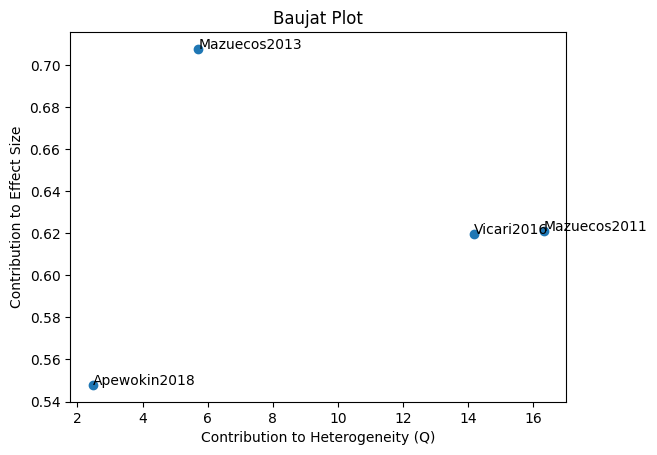

In [74]:
def perform_meta_analysis(valid_data):
    # Calculate log hazard ratios
    valid_data['log_hazard_ratio'] = np.log(valid_data['hazard_ratio'])
    
    # Variance of log hazard ratios
    valid_data['var_log_hazard_ratio'] = 1 / valid_data['sample_size']
    
    # Weights based on inverse variance
    w = 1 / np.array(valid_data['var_log_hazard_ratio'])
    z_bar = np.sum(w * valid_data['log_hazard_ratio']) / np.sum(w)
    k = len(valid_data['log_hazard_ratio'])
    Q = np.sum(w * (valid_data['log_hazard_ratio'] - z_bar)**2)
    
    # Calculating p-value for Q
    p_value_Q = 1 - chi2.cdf(Q, k - 1)

    if Q == k - 1:
        I2 = 0
    else:
        I2 = max(0, ((Q - (k - 1)) / Q) * 100)

    denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
    tau2 = 0 if denominator == 0 else (Q - (k - 1)) / denominator
    tau2 = max(0, tau2)  # Ensure non-negativity
    w_RE = 1 / (np.array(valid_data['var_log_hazard_ratio']) + tau2)
    w_RE_sum = np.sum(w_RE)
    if w_RE_sum == 0:
        z_bar_RE = 0
        weights_percent = [0] * k
    else:
        z_bar_RE = np.sum(w_RE * valid_data['log_hazard_ratio']) / w_RE_sum
        weights_percent = (w_RE / w_RE_sum) * 100

    se_z_bar_RE = np.sqrt(1 / np.sum(w_RE)) if w_RE_sum != 0 else 0
    ci_z_bar_RE = (z_bar_RE - 1.96*se_z_bar_RE, z_bar_RE + 1.96*se_z_bar_RE)

    # Calculate overall effect Z-value and p-value
    Z_value = z_bar_RE / se_z_bar_RE
    p_value_Z = 2 * (1 - norm.cdf(np.abs(Z_value)))

    # Back Transformation to hazard ratio scale
    hazard_ratio_bar_RE = np.exp(z_bar_RE)
    ci_hazard_ratio_bar_RE = (np.exp(ci_z_bar_RE[0]), np.exp(ci_z_bar_RE[1]))

    # Prepare DataFrame with study-specific results
    valid_data['effect_size'] = np.exp(valid_data['log_hazard_ratio'])
    valid_data['ci_lb'] = np.exp(valid_data['log_hazard_ratio'] - 1.96 * np.sqrt(valid_data['var_log_hazard_ratio']))
    valid_data['ci_ub'] = np.exp(valid_data['log_hazard_ratio'] + 1.96 * np.sqrt(valid_data['var_log_hazard_ratio']))
    valid_data['weight_percent'] = weights_percent

    # Create a DataFrame for the pooled result
    pooled_result = pd.DataFrame({
        'study_id': ['Pooled Estimate'],
        'sample_size': [np.sum(valid_data['sample_size'])],
        'effect_size': [hazard_ratio_bar_RE],
        'ci_lb': [ci_hazard_ratio_bar_RE[0]],
        'ci_ub': [ci_hazard_ratio_bar_RE[1]],
        'weight_percent': [np.sum(weights_percent)]
    })

    # Combine individual study results with the pooled result
    combined_results = pd.concat([valid_data[['study_id', 'sample_size', 'effect_size', 'ci_lb', 'ci_ub', 'weight_percent']], pooled_result])

    return hazard_ratio_bar_RE, ci_hazard_ratio_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z

def leave_one_out_analysis(valid_data):
    results = []
    for i in range(len(valid_data)):
        subset = valid_data.drop(valid_data.index[i])
        hazard_ratio_bar_RE, ci_hazard_ratio_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(subset)
        results.append({
            'study_id': valid_data.iloc[i]['study_id'],
            'hazard_ratio_bar_RE': hazard_ratio_bar_RE,
            'ci_hazard_ratio_bar_RE': ci_hazard_ratio_bar_RE,
            'I2': I2,
            'Q': Q,
            'p_value_Q': p_value_Q,
            'tau2': tau2,
            'Z_value': Z_value,
            'p_value_Z': p_value_Z
        })
    return results

def baujat_plot(valid_data, path):
    study_ids = valid_data['study_id'].unique()
    Q_contributions = []
    effect_contributions = []
    for study_id in study_ids:
        subset = valid_data[valid_data['study_id'] != study_id]
        hazard_ratio_bar_RE, _, _, I2, Q, _, _, _, _ = perform_meta_analysis(subset)
        Q_contributions.append(Q)
        effect_contributions.append(hazard_ratio_bar_RE)
    
    plt.scatter(Q_contributions, effect_contributions)
    for i, study_id in enumerate(study_ids):
        plt.annotate(study_id, (Q_contributions[i], effect_contributions[i]))
    plt.xlabel('Contribution to Heterogeneity (Q)')
    plt.ylabel('Contribution to Effect Size')
    plt.title('Baujat Plot')
    plt.savefig(path, dpi=1000)
    plt.show()

def q_statistic_decomposition(valid_data):
    hazard_ratio_bar_RE, _, _, _, _, _, _, _, _ = perform_meta_analysis(valid_data)
    valid_data['contribution_to_Q'] = valid_data['sample_size'] * (valid_data['log_hazard_ratio'] - np.log(hazard_ratio_bar_RE))**2
    return valid_data[['study_id', 'contribution_to_Q']]

def find_best_combination(valid_data):
    study_ids = valid_data['study_id'].unique()
    best_combination = None
    best_I2 = float('inf')
    best_combined_results = None
    best_hazard_ratio_bar_RE = None
    best_ci_hazard_ratio_bar_RE = None
    best_Q = None
    best_p_value_Q = None
    best_tau2 = None
    best_Z_value = None
    best_p_value_Z = None

    for r in range(len(study_ids), 0, -1):
        for combo in combinations(study_ids, r):
            subset = valid_data[valid_data['study_id'].isin(combo)]
            hazard_ratio_bar_RE, ci_hazard_ratio_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(subset)
            if I2 < 75 and len(combo) > len(best_combination or []):
                best_combination = combo
                best_I2 = I2
                best_combined_results = combined_results
                best_hazard_ratio_bar_RE = hazard_ratio_bar_RE
                best_ci_hazard_ratio_bar_RE = ci_hazard_ratio_bar_RE
                best_Q = Q
                best_p_value_Q = p_value_Q
                best_tau2 = tau2
                best_Z_value = Z_value
                best_p_value_Z = p_value_Z

    return best_combination, best_I2, best_combined_results, best_hazard_ratio_bar_RE, best_ci_hazard_ratio_bar_RE, best_Q, best_p_value_Q, best_tau2, best_Z_value, best_p_value_Z

def calculate_hazard_ratios(df, sample_size_col, sample_size_neg_col, study_id_col, group1_col, group2_col):
    # Select and filter the required columns
    selected_df = df[[study_id_col, sample_size_col, sample_size_neg_col, group1_col, group2_col]].dropna()
    
    # Convert survival probabilities from percentage to proportion
    selected_df[f'{group1_col}_prop'] = selected_df[group1_col] / 100
    selected_df[f'{group2_col}_prop'] = selected_df[group2_col] / 100

    # Convert survival probabilities to hazard rates
    selected_df[f'{group1_col}_hazard'] = -np.log(selected_df[f'{group1_col}_prop'])
    selected_df[f'{group2_col}_hazard'] = -np.log(selected_df[f'{group2_col}_prop'])

    # Avoid hazard rates of 0
    epsilon = 0.5 / np.min(selected_df[sample_size_col])
    selected_df[f'{group1_col}_hazard'] = np.where(selected_df[f'{group1_col}_hazard'] == 0, epsilon, selected_df[f'{group1_col}_hazard'])
    selected_df[f'{group2_col}_hazard'] = np.where(selected_df[f'{group2_col}_hazard'] == 0, epsilon, selected_df[f'{group2_col}_hazard'])

    # Calculate hazard ratios (HR)
    selected_df['hazard_ratio'] = selected_df[f'{group1_col}_hazard'] / selected_df[f'{group2_col}_hazard']
    selected_df['sample_size'] = selected_df[sample_size_col]
    
    return selected_df

pt_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_patient_survival_(%)_hiv+', '1-year_patient_survival_(%)_hiv-', 
                        '3-year_patient_survival_(%)_hiv+', '3-year_patient_survival_(%)_hiv-', 
                        '>=_5-year_patient_survival_(%)_hiv+', '>=_5-year_patient_survival_(%)_hiv-']]

gf_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_graft_survival_(%)_hiv+', '1-year_graft_survival_(%)_hiv-', 
                        '3-year_graft_survival_(%)_hiv+', '3-year_graft_survival_(%)_hiv-', 
                        '>=_5-year_graft_survival_(%)_hiv+', '>=_5-year_graft_survival_(%)_hiv-']]

rj_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_cumulative_graft_rejection_(%)_hiv+', '1-year_cumulative_graft_rejection_(%)_hiv-', 
                        '3-year_cumulative_graft_rejection_(%)_hiv+', '3-year_cumulative_graft_rejection_(%)_hiv-', 
                        '>=_5-year_cumulative_graft_rejection_(%)_hiv+', '>=_5-year_cumulative_graft_rejection_(%)_hiv-']]

# Rename columns
pt_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
gf_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
rj_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']

# Select and filter data for 5-year cumulative graft rejection
result_df = calculate_hazard_ratios(rj_survival_hr_df, 'sample_size_pos', 'sample_size_neg', 'study_id', '5_yr_pos', '5_yr_neg')

# Perform the meta-analysis on the full data
full_hazard_ratio_bar_RE, full_ci_hazard_ratio_bar_RE, full_combined_results, full_I2, full_Q, full_p_value_Q, full_tau2, full_Z_value, full_p_value_Z = perform_meta_analysis(result_df)

# Perform leave-one-out analysis
loo_results = leave_one_out_analysis(result_df)

# Generate Baujat plot
baujat_plot(result_df, '/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_rejection_hr_baujat_1000.png')

# Decompose Q-statistic
q_contributions = q_statistic_decomposition(result_df)

# Save results to JSON
full_combined_results_dict = full_combined_results.to_dict(orient='records')
loo_results_dict = loo_results
q_contributions_dict = q_contributions.to_dict(orient='records')
summary_results = {
    "Full_Data": {
        "Pooled_Hazard_Ratio": full_hazard_ratio_bar_RE,
        "95%_CI": full_ci_hazard_ratio_bar_RE,
        "I2": full_I2,
        "Q": full_Q,
        "p_value_for_Q": full_p_value_Q,
        "tau2": full_tau2,
        "Z": full_Z_value,
        "p_value_for_Z": full_p_value_Z,
        "combined_results": full_combined_results_dict
    },
    "Leave_One_Out_Analysis": loo_results_dict,
    "Q_Statistic_Decomposition": q_contributions_dict
}

summary_json_file_path = '/mnt/d/PYDataScience/HIV_TXP_SR/results/5_yr_gf_rejection_hr.json'  # Specify your desired path and filename here
with open(summary_json_file_path, 'w') as f:
    json.dump(summary_results, f, indent=4)

### 5. Univariable Meta-regression for effects of different factors on primary and secondary outcomes

In [200]:
def perform_meta_regression(df, study_id_col, sample_size_col, effect_size_col, categorical_cols, continuous_cols, output_json='meta_regression_results.json'):
    results = []

    # Convert effect measure to proportion if it's in percentage
    moderators = [col for col in df.columns if col not in [study_id_col, sample_size_col, effect_size_col]]
    
    # Analyze each variable (categorical and continuous)
    for col in moderators:
        mod_data = df[[study_id_col, sample_size_col, effect_size_col, col]].dropna().copy()
        mod_data.loc[:, 'effect_measure'] = mod_data[effect_size_col].copy() / 100
        epsilon = 0.5 / mod_data[sample_size_col].min()
        mod_data['effect_measure'] = np.clip(mod_data['effect_measure'], epsilon, 1 - epsilon)
        mod_data['logit_effect_measure'] = logit(mod_data['effect_measure'])

        # Calculate variance
        mod_data['var_logit_effect_measure'] = (
            1 / (mod_data[sample_size_col] * mod_data['effect_measure']) + 
            1 / (mod_data[sample_size_col] * (1 - mod_data['effect_measure']))
        )
        mod_data['weight'] = 1 / mod_data['var_logit_effect_measure']
        
        # Handle categorical variables
        if categorical_cols and col in categorical_cols:
            mod_data[col] = mod_data[col].astype('int')
        
        # Define your independent (X) and dependent (Y) variables
        X = mod_data[[col]]
        Y = mod_data['logit_effect_measure']
        weights = 1 / mod_data['var_logit_effect_measure']

        # Add a constant to the independent variable (for intercept)
        X = sm.add_constant(X)

        # Fit the fixed effects model
        try:
            if np.linalg.matrix_rank(X) < X.shape[1]:
                print(f"Multicollinearity detected in {col}. Skipping...")
                continue
            if len(mod_data) >= 2:
                print(f"Independent variable: {col}")
                print(f"Studies involved: {len(mod_data)}")
                fixed_effect_model = sm.WLS(Y, X, weights=weights).fit()
                fixed_effect_coefs = fixed_effect_model.params
                fixed_effect_se = fixed_effect_model.bse
                fixed_effect_ci_lower = fixed_effect_coefs - 1.96 * fixed_effect_se
                fixed_effect_ci_upper = fixed_effect_coefs + 1.96 * fixed_effect_se
                print(fixed_effect_model.summary())
                # Fit the random effects model
                random_effect_model = MixedLM(Y, X, groups=mod_data[study_id_col]).fit()
                random_effect_coefs = random_effect_model.params
                random_effect_se = random_effect_model.bse
                random_effect_ci_lower = random_effect_coefs - 1.96 * random_effect_se
                random_effect_ci_upper = random_effect_coefs + 1.96 * random_effect_se
                print(random_effect_model.summary())
                # Store results
                
                studies_details = []
                for i, study in mod_data.iterrows():
                    studies_details.append({
                        'study_id': study[study_id_col],
                        'fixed_effect': {
                            'coef': fixed_effect_coefs.loc[col],
                            'weight': weights[i],
                            'ci_lower': fixed_effect_ci_lower.loc[col],
                            'ci_upper': fixed_effect_ci_upper.loc[col],
                        },
                        'random_effect': {
                            'coef': random_effect_coefs.loc[col],
                            'weight': weights[i],
                            'ci_lower': random_effect_ci_lower.loc[col],
                            'ci_upper': random_effect_ci_upper.loc[col],
                        }
                    })
                results.append({
                    'variable': col,
                    'studies involved': mod_data[study_id_col].values.tolist(),
                    'studies_details': studies_details,
                    'fixed_effects': {
                        'coef': fixed_effect_model.params.tolist(),
                        'pvalues': fixed_effect_model.pvalues.tolist(),
                        'rsquared': fixed_effect_model.rsquared,
                        'aic': fixed_effect_model.aic,
                        'bic': fixed_effect_model.bic
                    },
                    'random_effects': {
                        'coef': random_effect_model.params.tolist(),
                        'pvalues': random_effect_model.pvalues.tolist(),
                        'group_variance': random_effect_model.cov_re.iloc[0, 0],
                        'log_likelihood': random_effect_model.llf
                    }
                })
        except np.linalg.LinAlgError as e:
            print(f"Linear algebra error in {col}: {e}")
        except Exception as e:
            print(f"Unexpected error in {col}: {e}")
            # Convert results to DataFrame and save to JSON
    results_df = pd.DataFrame(results)
    results_df.to_json(output_json, orient='records', indent=4)

    return results_df


subgp_df = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    # '1-year_patient_survival_(%)_hiv+',
    # '3-year_patient_survival_(%)_hiv+',
    '>=_5-year_patient_survival_(%)_hiv+',
    # '1-year_graft_survival_(%)_hiv+',
    # '3-year_graft_survival_(%)_hiv+',
    # '>=_5-year_graft_survival_(%)_hiv+',
    # '1-year_cumulative_graft_rejection_(%)_hiv+',
    # '3-year_cumulative_graft_rejection_(%)_hiv+',
    # '>=_5-year_cumulative_graft_rejection_(%)_hiv+',
    "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

subgp_df.columns = [
    'sample_size', 'study_id', 'outcome', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
subgp_df['ii_shift'] = subgp_df.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

subgp_df['pi_avoid'] = subgp_df.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

subgp_df['viral_breakthrough'] = subgp_df.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)
# Define categorical and continuous variables
categorical_cols = ['ii_shift', 'pi_avoid', 'viral_breakthrough']
continuous_cols = ['hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 
    'cd52', 
    'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post']

result_df = perform_meta_regression(subgp_df, 'study_id', 'sample_size', 'outcome', categorical_cols, continuous_cols, 
                                    output_json='/mnt/d/PYDataScience/HIV_TXP_SR/results/5_yr_pt_survival_subgp.json')
print(result_df)

/tmp/ipykernel_3486433/2520374679.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgp_df['ii_shift'] = subgp_df.apply(
/tmp/ipykernel_3486433/2520374679.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subgp_df['pi_avoid'] = subgp_df.apply(
/tmp/ipykernel_3486433/2520374679.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Independent variable: hivan
Studies involved: 6
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       0.006
Model:                              WLS   Adj. R-squared:                 -0.243
Method:                   Least Squares   F-statistic:                   0.02279
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):              0.887
Time:                          16:56:44   Log-Likelihood:                -5.2393
No. Observations:                     6   AIC:                             14.48
Df Residuals:                         4   BIC:                             14.06
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warni

### 6. Univariable Meta-regression for effects of different factors on the hazard ratio of primary and secondary outcomes

In [145]:
pt_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_patient_survival_(%)_hiv+', '1-year_patient_survival_(%)_hiv-', 
                        '3-year_patient_survival_(%)_hiv+', '3-year_patient_survival_(%)_hiv-', 
                        '>=_5-year_patient_survival_(%)_hiv+', '>=_5-year_patient_survival_(%)_hiv-']]

gf_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_graft_survival_(%)_hiv+', '1-year_graft_survival_(%)_hiv-', 
                        '3-year_graft_survival_(%)_hiv+', '3-year_graft_survival_(%)_hiv-', 
                        '>=_5-year_graft_survival_(%)_hiv+', '>=_5-year_graft_survival_(%)_hiv-']]

rj_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
                        '1-year_cumulative_graft_rejection_(%)_hiv+', '1-year_cumulative_graft_rejection_(%)_hiv-', 
                        '3-year_cumulative_graft_rejection_(%)_hiv+', '3-year_cumulative_graft_rejection_(%)_hiv-', 
                        '>=_5-year_cumulative_graft_rejection_(%)_hiv+', '>=_5-year_cumulative_graft_rejection_(%)_hiv-']]

# Rename columns
pt_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
gf_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
rj_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg',  'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']

# Select and filter data for 5-year cumulative graft rejection
result_df = calculate_hazard_ratios(rj_survival_hr_df, 'sample_size_pos', 'sample_size_neg', 'study_id', '5_yr_pos', '5_yr_neg')
selected_columns_df = df[['study_id', "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]
selected_columns_df.columns = [
    'study_id', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]
merged_df = pd.merge(result_df, selected_columns_df, on='study_id', how='inner')

merged_df['ii_shift'] = merged_df.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

merged_df['pi_avoid'] = merged_df.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

merged_df['viral_breakthrough'] = merged_df.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)
categorical_cols = ['ii_shift', 'pi_avoid', 'viral_breakthrough']
continuous_cols = ['hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 
    'cd52', 
    'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post']

merged_df = merged_df[['sample_size', 'study_id', 'hazard_ratio'] + categorical_cols + continuous_cols].copy()

result_df = perform_meta_regression(merged_df, 'study_id', 'sample_size', 'hazard_ratio', categorical_cols, continuous_cols, 
                                    output_json='/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_rejection_hr_subgp.json')
print(result_df)

Unexpected error in ii_shift: zero-size array to reduction operation maximum which has no identity
Multicollinearity detected in pi_avoid. Skipping...
Multicollinearity detected in viral_breakthrough. Skipping...
Independent variable: hcv
Studies involved: 3
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                      -0.882
Model:                              WLS   Adj. R-squared:                 -2.764
Method:                   Least Squares   F-statistic:                   -0.4686
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):               1.00
Time:                          11:59:31   Log-Likelihood:                 100.73
No. Observations:                     3   AIC:                            -197.5
Df Residuals:                         1   BIC:                            -199.3
Df Model:                             1                                         
Covariance T

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/home/goma/minic

### 7. Multivariate Meta-regression for effects of different factors on primary and secondary outcomes and hazard ratio:
#### Get significant factors affecting the outcomes first:

In [201]:
# Load the JSON files
files = [
    "/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_gf_rejection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_gf_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_infection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_pt_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_gf_rejection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_gf_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_infection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_pt_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_rejection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_survival_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_infection_subgp.json",
    "/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_pt_survival_subgp.json"
]

factors_data = []

for file in files:
    filename = file.split('/')[-1]
    with open(file, 'r') as f:
        data = json.load(f)
        for item in data:
            variable = item.get('variable')
            random_effects = item.get('random_effects', {})
            for coef, pvalue in zip(random_effects.get('coef', []), random_effects.get('pvalues', [])):
                factors_data.append({
                    "Factor": variable,
                    "Effect Type": "Random",
                    "Coefficient": coef,
                    "P-Value": pvalue,
                    "File Source": filename
                })

# Create a DataFrame from the extracted data
factors_df = pd.DataFrame(factors_data)
factors_df = factors_df.groupby(['Factor', 'File Source']).apply(lambda x: x.iloc[1]).reset_index(drop=True)
factors_df = factors_df.loc[(factors_df['P-Value'] < 0.05) & (factors_df['P-Value'] > 0), :]
pivot_factors = factors_df.pivot_table(
    columns='Factor',
    index='File Source',
    values='Coefficient',
    aggfunc='min'  # Use the minimum p-value if multiple exist
)
factors_with_values = pivot_factors.apply(lambda row: row.dropna().index.tolist(), axis=1)

# Dictionary to hold the number of studies for each factor and file source
study_counts = {}

# Iterate through the JSON files and count studies
for file in files:
    filename = file.split('/')[-1]
    with open(file, 'r') as f:
        data = json.load(f)
        for item in data:
            factor = item.get('variable')
            studies = len(item.get('studies_details', []))
            study_counts[(filename, factor)] = studies

# Create a DataFrame to show the number of studies for each factor in each file source
study_counts_df = pd.DataFrame.from_dict(study_counts, orient='index', columns=['Number of Studies'])

# Reset the index to separate the File Source and Factor columns
study_counts_df = study_counts_df.reset_index()
# The 'index' column will contain tuples, so we'll split them
study_counts_df[['File Source', 'Factor']] = pd.DataFrame(study_counts_df['index'].tolist(), index=study_counts_df.index)

# Match this DataFrame with the factors_with_values Series
matched_study_counts = []

for file_source, factors in factors_with_values.items():
    for factor in factors:
        count = study_counts_df.loc[(study_counts_df['File Source'] == file_source) & (study_counts_df['Factor'] == factor), 'Number of Studies'].values
        if len(count) > 0:
            matched_study_counts.append({
                "File Source": file_source,
                "Factor": factor,
                "Number of Studies": count[0]
            })

# Convert the matched study counts to a DataFrame
matched_study_counts_df = pd.DataFrame(matched_study_counts)
sig_factor_df = pd.merge(matched_study_counts_df, factors_df[['Factor', 'Coefficient', 'P-Value', 'File Source']], on=['File Source', 'Factor'], how='inner')
sig_factor_df = sig_factor_df[sig_factor_df['Number of Studies']>9]


/tmp/ipykernel_3486433/509164471.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  factors_df = factors_df.groupby(['Factor', 'File Source']).apply(lambda x: x.iloc[1]).reset_index(drop=True)


In [202]:
sig_factor_df

,File Source,Factor,Number of Studies,Coefficient,P-Value
0,1_yr_gf_rejection_subgp.json,hivan,16,-1.074219,7.000000e-10
1,1_yr_gf_rejection_subgp.json,ii_pre,10,-0.931811,2.803128e-02
2,1_yr_gf_rejection_subgp.json,induction_use,17,-0.627298,4.202483e-02
3,1_yr_gf_rejection_subgp.json,nnrti_post,13,4.038801,3.321911e-18
4,1_yr_gf_rejection_subgp.json,nnrti_pre,12,0.912560,1.433186e-02
5,1_yr_gf_rejection_subgp.json,pi_avoid,12,-0.724255,1.618782e-21
6,1_yr_gf_rejection_subgp.json,viral_breakthrough,11,0.956760,7.448092e-03
7,1_yr_gf_survival_subgp.json,cd4,16,-0.000648,1.290000e-08
8,1_yr_gf_survival_subgp.json,hbv,13,6.179696,1.405385e-02
9,1_yr_gf_survival_subgp.json,hcv,19,-0.682733,3.891907e-02


|    | File Source                  | Factor                                                                                                                             |
|---:|:-----------------------------|:-----------------------------------------------------------------------------------------------------------------------------------|
|  0 | 1_yr_gf_rejection_subgp.json | ['hivan', 'pi_avoid', 'viral_breakthrough']                          |
|  1 | 1_yr_gf_survival_subgp.json  | ['hbv', 'hcv', 'cd4', 'ii_shift', 'pi_avoid', 'viral_suppress_post'] |
|  2 | 1_yr_pt_survival_subgp.json  | ['atg', 'cd4', 'nnrti_post', 'pi_avoid']                                                                      |
|  3 | 3_yr_gf_survival_subgp.json  | ['cd4', 'pi_avoid']                                                                                                     |
|  4 | 3_yr_pt_survival_subgp.json  | ['atg', 'induction_use', 'viral_suppress_pre']                                                                                            |
|  5 | 5_yr_gf_survival_subgp.json  | ['hcv']                                                                                                                            |
|  6 | 5_yr_pt_survival_subgp.json  | ['hivan', 'pi_avoid']                                                                                                                            |

In [189]:

def perform_multivariate_meta_regression(df, study_id_col, sample_size_col, effect_size_col, categorical_cols, continuous_cols, output_json='meta_regression_results.json'):
    results = []

    # Select all moderators (categorical and continuous)
    moderators = categorical_cols + continuous_cols
    
    # Prepare the dataset with selected moderators
    mod_data = df[[study_id_col, sample_size_col, effect_size_col] + moderators].dropna().copy()
    
    # Convert effect size to proportion if it's in percentage
    mod_data.loc[:, 'effect_measure'] = mod_data[effect_size_col].copy() / 100
    epsilon = 0.5 / mod_data[sample_size_col].min()
    mod_data['effect_measure'] = np.clip(mod_data['effect_measure'], epsilon, 1 - epsilon)
    mod_data['logit_effect_measure'] = logit(mod_data['effect_measure'])

    # Calculate variance
    mod_data['var_logit_effect_measure'] = (
        1 / (mod_data[sample_size_col] * mod_data['effect_measure']) + 
        1 / (mod_data[sample_size_col] * (1 - mod_data['effect_measure']))
    )
    mod_data['weight'] = 1 / mod_data['var_logit_effect_measure']
    
    # Handle categorical variables
    if categorical_cols:
        for col in categorical_cols:
            mod_data[col] = mod_data[col].astype('int')
    # print(mod_data)
    # Define the independent (X) and dependent (Y) variables
    X = mod_data[moderators]
    Y = mod_data['logit_effect_measure']
    weights = 1 / mod_data['var_logit_effect_measure']

    # Add a constant to the independent variables (for intercept)
    X = sm.add_constant(X)

    # Fit the fixed effects model
    try:
        if np.linalg.matrix_rank(X) < X.shape[1]:
            print(f"Multicollinearity detected. Skipping...")
        else:
            if len(mod_data) >= 2:
                print(f"Performing multivariate meta-regression...")
                fixed_effect_model = sm.WLS(Y, X, weights=weights).fit()
                fixed_effect_coefs = fixed_effect_model.params
                fixed_effect_se = fixed_effect_model.bse
                fixed_effect_ci_lower = fixed_effect_coefs - 1.96 * fixed_effect_se
                fixed_effect_ci_upper = fixed_effect_coefs + 1.96 * fixed_effect_se
                print(fixed_effect_model.summary())
                
                # Fit the random effects model
                random_effect_model = MixedLM(Y, X, groups=mod_data[study_id_col]).fit()
                random_effect_coefs = random_effect_model.params
                random_effect_se = random_effect_model.bse
                random_effect_ci_lower = random_effect_coefs - 1.96 * random_effect_se
                random_effect_ci_upper = random_effect_coefs + 1.96 * random_effect_se
                print(random_effect_model.summary())
                
                # Store the results
                results.append({
                    'studies_involved': mod_data[study_id_col].values.tolist(),
                    'factors': moderators,
                    'fixed_effects': {
                        'coef': fixed_effect_model.params.tolist(),
                        'upper_ci': fixed_effect_ci_upper,
                        'lower_ci': fixed_effect_ci_lower,                        
                        'pvalues': fixed_effect_model.pvalues.tolist(),
                        'rsquared': fixed_effect_model.rsquared,
                        'aic': fixed_effect_model.aic,
                        'bic': fixed_effect_model.bic
                    },
                    'random_effects': {
                        'coef': random_effect_model.params.tolist(),
                        'upper_ci': random_effect_ci_upper,
                        'lower_ci': random_effect_ci_lower, 
                        'pvalues': random_effect_model.pvalues.tolist(),
                        'group_variance': random_effect_model.cov_re.iloc[0, 0],
                        'log_likelihood': random_effect_model.llf
                    }
                })
    except np.linalg.LinAlgError as e:
        print(f"Linear algebra error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    
    # Convert results to DataFrame and save to JSON
    results_df = pd.DataFrame(results)
    results_df.to_json(output_json, orient='records', indent=4)

    return results_df

print('1_yr_graft_rejection')
categorical_cols = ['pi_avoid', 'viral_breakthrough']
continuous_cols = []

gr_df_1 = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    # '1-year_patient_survival_(%)_hiv+',
    # '3-year_patient_survival_(%)_hiv+',
    # '>=_5-year_patient_survival_(%)_hiv+',
    # '1-year_graft_survival_(%)_hiv+',
    # '3-year_graft_survival_(%)_hiv+',
    # '>=_5-year_graft_survival_(%)_hiv+',
    '1-year_cumulative_graft_rejection_(%)_hiv+',
    # '3-year_cumulative_graft_rejection_(%)_hiv+',
    # '>=_5-year_cumulative_graft_rejection_(%)_hiv+',
    "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

gr_df_1.columns = [
    'sample_size', 'study_id', 'outcome', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
gr_df_1['ii_shift'] = gr_df_1.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

gr_df_1['pi_avoid'] = gr_df_1.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

gr_df_1['viral_breakthrough'] = gr_df_1.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)

# Perform multivariate meta-regression
gf_rj_1_multi = perform_multivariate_meta_regression(gr_df_1, 'study_id', 'sample_size', 'outcome', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_gf_rejection_multi_regression.json')


1_yr_graft_rejection
Performing multivariate meta-regression...
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       0.198
Model:                              WLS   Adj. R-squared:                 -0.069
Method:                   Least Squares   F-statistic:                    0.7416
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):              0.515
Time:                          16:10:18   Log-Likelihood:                -8.4716
No. Observations:                     9   AIC:                             22.94
Df Residuals:                         6   BIC:                             23.53
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/tmp/ipykernel_3486433/1991761210.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_df_1['ii_shift'] = gr_df_1.apply(
/tmp/ipykernel_3486433/1991761210.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_df_1['pi_avoid'] = gr_df_1.apply(
/tmp/ipykernel_3486433/1991761210.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [180]:

print('1_yr_graft_survival')
categorical_cols = ['pi_avoid']
continuous_cols = ['hcv']
gs_df_1 = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    # '1-year_patient_survival_(%)_hiv+',
    # '3-year_patient_survival_(%)_hiv+',
    # '>=_5-year_patient_survival_(%)_hiv+',
    '1-year_graft_survival_(%)_hiv+',
    # '3-year_graft_survival_(%)_hiv+',
    # '>=_5-year_graft_survival_(%)_hiv+',
    # '1-year_cumulative_graft_rejection_(%)_hiv+',
    # '3-year_cumulative_graft_rejection_(%)_hiv+',
    # '>=_5-year_cumulative_graft_rejection_(%)_hiv+',
    "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

gs_df_1.columns = [
    'sample_size', 'study_id', 'outcome', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
gs_df_1['ii_shift'] = gs_df_1.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

gs_df_1['pi_avoid'] = gs_df_1.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

gs_df_1['viral_breakthrough'] = gs_df_1.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)

# Perform multivariate meta-regression
gf_sv_1_multi = perform_multivariate_meta_regression(gs_df_1, 'study_id', 'sample_size', 'outcome', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_gf_survival_multi_regression.json')


1_yr_graft_survival
Performing multivariate meta-regression...
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       0.456
Model:                              WLS   Adj. R-squared:                  0.335
Method:                   Least Squares   F-statistic:                     3.771
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):             0.0646
Time:                          14:54:32   Log-Likelihood:                -3.3867
No. Observations:                    12   AIC:                             12.77
Df Residuals:                         9   BIC:                             14.23
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/tmp/ipykernel_3486433/1537522689.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_df_1['ii_shift'] = gs_df_1.apply(
/tmp/ipykernel_3486433/1537522689.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_df_1['pi_avoid'] = gs_df_1.apply(
/tmp/ipykernel_3486433/1537522689.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [181]:

print('1_yr_pt_survival')
categorical_cols = ['pi_avoid']
continuous_cols = ['atg', 'cd4'] 
ps_df_1 = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    '1-year_patient_survival_(%)_hiv+',
    # '3-year_patient_survival_(%)_hiv+',
    # '>=_5-year_patient_survival_(%)_hiv+',
    # '1-year_graft_survival_(%)_hiv+',
    # '3-year_graft_survival_(%)_hiv+',
    # '>=_5-year_graft_survival_(%)_hiv+',
    # '1-year_cumulative_graft_rejection_(%)_hiv+',
    # '3-year_cumulative_graft_rejection_(%)_hiv+',
    # '>=_5-year_cumulative_graft_rejection_(%)_hiv+',
    "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

ps_df_1.columns = [
    'sample_size', 'study_id', 'outcome', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
ps_df_1['ii_shift'] = ps_df_1.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

ps_df_1['pi_avoid'] = ps_df_1.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

ps_df_1['viral_breakthrough'] = ps_df_1.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)

pt_sv_1_multi = perform_multivariate_meta_regression(ps_df_1, 'study_id', 'sample_size', 'outcome', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/1_yr_pt_survival_multi_regression.json')


1_yr_pt_survival
Performing multivariate meta-regression...
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       0.948
Model:                              WLS   Adj. R-squared:                  0.896
Method:                   Least Squares   F-statistic:                     18.22
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):             0.0198
Time:                          15:32:09   Log-Likelihood:                 3.3148
No. Observations:                     7   AIC:                             1.370
Df Residuals:                         3   BIC:                             1.154
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/tmp/ipykernel_3486433/4063461353.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_df_1['ii_shift'] = ps_df_1.apply(
/tmp/ipykernel_3486433/4063461353.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_df_1['pi_avoid'] = ps_df_1.apply(
/tmp/ipykernel_3486433/4063461353.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [183]:

print('3_yr_gf_survival')
categorical_cols = ['pi_avoid']
continuous_cols = ['cd4'] 

gs_df_3 = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    # '1-year_patient_survival_(%)_hiv+',
    # '3-year_patient_survival_(%)_hiv+',
    # '>=_5-year_patient_survival_(%)_hiv+',
    # '1-year_graft_survival_(%)_hiv+',
    '3-year_graft_survival_(%)_hiv+',
    # '>=_5-year_graft_survival_(%)_hiv+',
    # '1-year_cumulative_graft_rejection_(%)_hiv+',
    # '3-year_cumulative_graft_rejection_(%)_hiv+',
    # '>=_5-year_cumulative_graft_rejection_(%)_hiv+',
    "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

gs_df_3.columns = [
    'sample_size', 'study_id', 'outcome', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
gs_df_3['ii_shift'] = gs_df_3.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

gs_df_3['pi_avoid'] = gs_df_3.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

gs_df_3['viral_breakthrough'] = gs_df_3.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)
gf_sv_3_multi = perform_multivariate_meta_regression(gs_df_3, 'study_id', 'sample_size', 'outcome', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_gf_survival_multi_regression.json')


3_yr_gf_survival
Performing multivariate meta-regression...
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       0.091
Model:                              WLS   Adj. R-squared:                 -0.212
Method:                   Least Squares   F-statistic:                    0.2995
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):              0.752
Time:                          15:50:06   Log-Likelihood:                -9.0869
No. Observations:                     9   AIC:                             24.17
Df Residuals:                         6   BIC:                             24.77
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/tmp/ipykernel_3486433/2167819377.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_df_3['ii_shift'] = gs_df_3.apply(
/tmp/ipykernel_3486433/2167819377.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_df_3['pi_avoid'] = gs_df_3.apply(
/tmp/ipykernel_3486433/2167819377.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [198]:

print('3_yr_pt_survival')
categorical_cols = []
continuous_cols = ['induction_use', 'cd4', 'atg'] 

ps_df_3 = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    # '1-year_patient_survival_(%)_hiv+',
    '3-year_patient_survival_(%)_hiv+',
    # '>=_5-year_patient_survival_(%)_hiv+',
    # '1-year_graft_survival_(%)_hiv+',
    # '3-year_graft_survival_(%)_hiv+',
    # '>=_5-year_graft_survival_(%)_hiv+',
    # '1-year_cumulative_graft_rejection_(%)_hiv+',
    # '3-year_cumulative_graft_rejection_(%)_hiv+',
    # '>=_5-year_cumulative_graft_rejection_(%)_hiv+',
    "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

ps_df_3.columns = [
    'sample_size', 'study_id', 'outcome', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
ps_df_3['ii_shift'] = ps_df_3.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

ps_df_3['pi_avoid'] = ps_df_3.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

ps_df_3['viral_breakthrough'] = ps_df_3.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)
pt_sv_3_multi = perform_multivariate_meta_regression(ps_df_3, 'study_id', 'sample_size', 'outcome', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/3_yr_pt_survival_multi_regression.json')


3_yr_pt_survival
Performing multivariate meta-regression...
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       0.656
Model:                              WLS   Adj. R-squared:                 -0.376
Method:                   Least Squares   F-statistic:                    0.6354
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):              0.701
Time:                          16:24:45   Log-Likelihood:                -2.8585
No. Observations:                     5   AIC:                             13.72
Df Residuals:                         1   BIC:                             12.15
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/tmp/ipykernel_3486433/3437307814.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_df_3['ii_shift'] = ps_df_3.apply(
/tmp/ipykernel_3486433/3437307814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_df_3['pi_avoid'] = ps_df_3.apply(
/tmp/ipykernel_3486433/3437307814.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [185]:

print('5_yr_gf_survival')
categorical_cols = []
continuous_cols = ['hcv'] 
gs_df_5 = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    # '1-year_patient_survival_(%)_hiv+',
    # '3-year_patient_survival_(%)_hiv+',
    # '>=_5-year_patient_survival_(%)_hiv+',
    # '1-year_graft_survival_(%)_hiv+',
    # '3-year_graft_survival_(%)_hiv+',
    '>=_5-year_graft_survival_(%)_hiv+',
    # '1-year_cumulative_graft_rejection_(%)_hiv+',
    # '3-year_cumulative_graft_rejection_(%)_hiv+',
    # '>=_5-year_cumulative_graft_rejection_(%)_hiv+',
    "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

gs_df_5.columns = [
    'sample_size', 'study_id', 'outcome', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
gs_df_5['ii_shift'] = gs_df_5.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

gs_df_5['pi_avoid'] = gs_df_5.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

gs_df_5['viral_breakthrough'] = gs_df_5.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)

gf_sv_5_multi = perform_multivariate_meta_regression(gs_df_5, 'study_id', 'sample_size', 'outcome', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_gf_survival_multi_regression.json')

5_yr_gf_survival
Performing multivariate meta-regression...
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       0.380
Model:                              WLS   Adj. R-squared:                  0.302
Method:                   Least Squares   F-statistic:                     4.902
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):             0.0577
Time:                          15:53:57   Log-Likelihood:               -0.87577
No. Observations:                    10   AIC:                             5.752
Df Residuals:                         8   BIC:                             6.357
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/tmp/ipykernel_3486433/4037250817.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_df_5['ii_shift'] = gs_df_5.apply(
/tmp/ipykernel_3486433/4037250817.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_df_5['pi_avoid'] = gs_df_5.apply(
/tmp/ipykernel_3486433/4037250817.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [188]:

print('5_yr_pt_survival')
categorical_cols = ['pi_avoid']
continuous_cols = ['hivan'] 
ps_df_5 = df[[
    'sample_size_(hiv_seropositive_only)', 'study_id', 
    # '1-year_patient_survival_(%)_hiv+',
    # '3-year_patient_survival_(%)_hiv+',
    '>=_5-year_patient_survival_(%)_hiv+',
    # '1-year_graft_survival_(%)_hiv+',
    # '3-year_graft_survival_(%)_hiv+',
    # '>=_5-year_graft_survival_(%)_hiv+',
    # '1-year_cumulative_graft_rejection_(%)_hiv+',
    # '3-year_cumulative_graft_rejection_(%)_hiv+',
    # '>=_5-year_cumulative_graft_rejection_(%)_hiv+',
    "hivan_pre-transplant",
    "hcv_coinfection_antihcv", "hbv_coinfection_hbsag", "cd4_count_cells/mm3_pre-transplant",
    "viral_suppression_(<=_50copies/mm3)_pre-transplant", 
    "viral_suppression_(<=_50copies/mm3)_post-transplant_1_year",
    "induction_atg", "induction_il-2", "induction_anti-cd52",
    "induction_total", "integrase_inhibitor__total_pre-tx",
    "integrase_inhibitor__total_post-tx", "protease_inhibitor_total_pre-tx",
    "protease_inhibitor_total_post-tx", "nrti_total_pre-tx",
    "nrti_total_post-tx", "nnrti_total_pre-tx", "nnrti_total_post-tx"
]]

ps_df_5.columns = [
    'sample_size', 'study_id', 'outcome', 'hivan', 'hcv', 'hbv','cd4', 'viral_suppress_pre', 
    'viral_suppress_post','atg', 'il_2', 'cd52', 'induction_use', 
    'ii_pre', 'ii_post', 'pi_pre', 'pi_post', 'nrti_pre', 'nrti_post', 
    'nnrti_pre', 'nnrti_post'
]

# Create new columns only when both columns have non-null values
ps_df_5['ii_shift'] = ps_df_5.apply(
    lambda row: row['ii_pre'] < row['ii_post'] if pd.notnull(row['ii_pre']) and pd.notnull(row['ii_post']) else np.nan, axis=1
)

ps_df_5['pi_avoid'] = ps_df_5.apply(
    lambda row: row['pi_pre'] > row['pi_post'] if pd.notnull(row['pi_pre']) and pd.notnull(row['pi_post']) else np.nan, axis=1
)

ps_df_5['viral_breakthrough'] = ps_df_5.apply(
    lambda row: row['viral_suppress_pre'] > row['viral_suppress_post'] if pd.notnull(row['viral_suppress_pre']) and pd.notnull(row['viral_suppress_post']) else np.nan, axis=1
)

gf_sv_5_multi = perform_multivariate_meta_regression(ps_df_5, 'study_id', 'sample_size', 'outcome', 
                                                     categorical_cols, continuous_cols, 
                                                     output_json='/mnt/d/pydatascience/hiv_txp_sr/results/5_yr_pt_survival_multi_regression.json')

5_yr_pt_survival
Performing multivariate meta-regression...
                             WLS Regression Results                             
Dep. Variable:     logit_effect_measure   R-squared:                       1.000
Model:                              WLS   Adj. R-squared:                    nan
Method:                   Least Squares   F-statistic:                       nan
Date:                  Wed, 01 Jan 2025   Prob (F-statistic):                nan
Time:                          16:07:41   Log-Likelihood:                 95.106
No. Observations:                     3   AIC:                            -184.2
Df Residuals:                         0   BIC:                            -186.9
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/tmp/ipykernel_3486433/1434064625.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_df_5['ii_shift'] = ps_df_5.apply(
/tmp/ipykernel_3486433/1434064625.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_df_5['pi_avoid'] = ps_df_5.apply(
/tmp/ipykernel_3486433/1434064625.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

### 8. Sensitivity analysis


#### Data synthesis by nature of trial (prospective or retrospective)
#### Primary and secondary outcome

In [93]:
# Assuming the perform_meta_analysis function is already defined

def meta_analysis_wrapper(retro_data, pros_data, outcome_columns, outcome_label, output_json_prefix):
    for outcome in outcome_columns:
        # Retrospective meta-analysis
        retro_data['proportion'] = retro_data[outcome] / 100
        valid_data_retro = retro_data[['study_id', 'sample_size', 'proportion']].dropna()
        
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(valid_data_retro)
        
        print(f"Retrospective {outcome_label} {outcome}:")
        print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
        print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
        print(f"I²: {I2:.2f}%")
        print(f"Q: {Q:.2f}")
        print(f"p-value for Q: {p_value_Q:.4f}")
        print(f"tau2: {tau2:.4f}")
        
        summary_results = {
            "Pooled_Survival_Proportion": proportion_bar_RE,
            "95%_CI": ci_proportion_bar_RE,
            "I2": I2,
            "Q": Q,
            "p_value_for_Q": p_value_Q,
            "tau2": tau2,
            "combined_results": combined_results.to_dict(orient='records')
        }
        
        summary_json_file_path = f'{output_json_prefix}_retro_{outcome}.json'
        with open(summary_json_file_path, 'w') as f:
            json.dump(summary_results, f, indent=4)
        
        # Prospective meta-analysis
        pros_data['proportion'] = pros_data[outcome] / 100
        valid_data_pros = pros_data[['study_id', 'sample_size', 'proportion']].dropna()
        
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(valid_data_pros)
        
        print(f"Prospective {outcome_label} {outcome}:")
        print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
        print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
        print(f"I²: {I2:.2f}%")
        print(f"Q: {Q:.2f}")
        print(f"p-value for Q: {p_value_Q:.4f}")
        print(f"tau2: {tau2:.4f}")
        
        summary_results = {
            "Pooled_Survival_Proportion": proportion_bar_RE,
            "95%_CI": ci_proportion_bar_RE,
            "I2": I2,
            "Q": Q,
            "p_value_for_Q": p_value_Q,
            "tau2": tau2,
            "combined_results": combined_results.to_dict(orient='records')
        }
        
        summary_json_file_path = f'{output_json_prefix}_pros_{outcome}.json'
        with open(summary_json_file_path, 'w') as f:
            json.dump(summary_results, f, indent=4)

# Load and prepare the data
pt_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_patient_survival_(%)_hiv+', '1-year_patient_survival_(%)_hiv-', 
                        '3-year_patient_survival_(%)_hiv+', '3-year_patient_survival_(%)_hiv-', 
                        '>=_5-year_patient_survival_(%)_hiv+', '>=_5-year_patient_survival_(%)_hiv-']]

gf_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_graft_survival_(%)_hiv+', '1-year_graft_survival_(%)_hiv-', 
                        '3-year_graft_survival_(%)_hiv+', '3-year_graft_survival_(%)_hiv-', 
                        '>=_5-year_graft_survival_(%)_hiv+', '>=_5-year_graft_survival_(%)_hiv-']]

rj_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'study_id',
                        '1-year_cumulative_graft_rejection_(%)_hiv+', '1-year_cumulative_graft_rejection_(%)_hiv-', 
                        '3-year_cumulative_graft_rejection_(%)_hiv+', '3-year_cumulative_graft_rejection_(%)_hiv-', 
                        '>=_5-year_cumulative_graft_rejection_(%)_hiv+', '>=_5-year_cumulative_graft_rejection_(%)_hiv-']]

# Rename columns
pt_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
gf_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
rj_survival_hr_df.columns = ['sample_size', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']

qos_df = df[['study_id', 'nos_outcome_total_(max_9_stars)', 'cochrane_rob_risk_of_bias_in_selection_of_the_reported_result_overall_risk_of_bias', 'robins-i_v2_overall_risk_of_bias']]
qos_df.columns = ['study_id', 'nos', 'rob', 'final_rob']

# Grouping of retrospective and prospective trials
# Retrospectve trials and outcomes:
retro_df = qos_df[['study_id', 'nos']].copy().dropna()
pt_survival_retro_data = pd.merge(retro_df, pt_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')
gf_survival_retro_data = pd.merge(retro_df, gf_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')
rj_survival_retro_data = pd.merge(retro_df, rj_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')

# Prospective trials and outcomes:
pros_df = qos_df[['study_id', 'rob']].copy().dropna()
pt_survival_pros_data = pd.merge(pros_df, pt_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')
gf_survival_pros_data = pd.merge(pros_df, gf_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')
rj_survival_pros_data = pd.merge(pros_df, rj_survival_hr_df[['sample_size', 'study_id', '1_yr_pos', '3_yr_pos', '5_yr_pos']], how='left', on='study_id')

outcome_columns = ['1_yr_pos', '3_yr_pos', '5_yr_pos']
meta_analysis_wrapper(pt_survival_retro_data, pt_survival_pros_data, outcome_columns, 'pt_survival', '/mnt/d/pydatascience/hiv_txp_sr/results/pt_survival')
meta_analysis_wrapper(gf_survival_retro_data, gf_survival_pros_data, outcome_columns, 'gf_survival', '/mnt/d/pydatascience/hiv_txp_sr/results/gf_survival')
meta_analysis_wrapper(rj_survival_retro_data, rj_survival_pros_data, outcome_columns, 'rj_survival', '/mnt/d/pydatascience/hiv_txp_sr/results/rj_survival')

Retrospective pt_survival 1_yr_pos:
Pooled Proportion: 0.9413
95% CI: (0.9290, 0.9516)
I²: 0.00%
Q: 7.92
p-value for Q: 0.9875
tau2: 0.0000
Prospective pt_survival 1_yr_pos:
Pooled Proportion: 0.9359
95% CI: (0.9047, 0.9574)
I²: 12.98%
Q: 4.60
p-value for Q: 0.3312
tau2: 0.0328
Retrospective pt_survival 3_yr_pos:
Pooled Proportion: 0.8999
95% CI: (0.8736, 0.9212)
I²: 41.16%
Q: 28.89
p-value for Q: 0.0355
tau2: 0.0878
Prospective pt_survival 3_yr_pos:
Pooled Proportion: 0.8699
95% CI: (0.8348, 0.8984)
I²: 0.00%
Q: 0.79
p-value for Q: 0.8508
tau2: 0.0000
Retrospective pt_survival 5_yr_pos:
Pooled Proportion: 0.8351
95% CI: (0.7698, 0.8847)
I²: 62.28%
Q: 31.82
p-value for Q: 0.0015
tau2: 0.2770
Prospective pt_survival 5_yr_pos:
Pooled Proportion: 0.7400
95% CI: (0.5464, 0.8706)
I²: 0.00%
Q: 0.00
p-value for Q: nan
tau2: 0.0000
Retrospective gf_survival 1_yr_pos:
Pooled Proportion: 0.9006
95% CI: (0.8850, 0.9142)
I²: 0.00%
Q: 10.56
p-value for Q: 0.9379
tau2: 0.0000
Prospective gf_survival

In [139]:
df['country_of_study'].value_counts()

country_of_study
USA                                                  31
Spain                                                 5
France                                                3
Italy                                                 3
UK                                                    3
South Africa                                          2
Multi-country (United States, Switzerland, Spain)     1
Brazil                                                1
Name: count, dtype: int64

#### Hazard ratio of primary outcome

In [98]:
def calculate_hr_wrapper(df, sample_size_col, neg_sample_size_col, study_id_col):
    # Calculate hazard ratios for 1-year survival
    hr_1yr_df = calculate_hazard_ratios(df, sample_size_col, neg_sample_size_col, study_id_col, '1_yr_pos', '1_yr_neg')
    hr_1yr_df = hr_1yr_df.rename(columns={'hazard_ratio': '1_yr_hr'})

    # Calculate hazard ratios for 3-year survival
    hr_3yr_df = calculate_hazard_ratios(df, sample_size_col, neg_sample_size_col, study_id_col, '3_yr_pos', '3_yr_neg')
    hr_3yr_df = hr_3yr_df.rename(columns={'hazard_ratio': '3_yr_hr'})

    # Calculate hazard ratios for 5-year survival
    hr_5yr_df = calculate_hazard_ratios(df, sample_size_col, neg_sample_size_col, study_id_col, '5_yr_pos', '5_yr_neg')
    hr_5yr_df = hr_5yr_df.rename(columns={'hazard_ratio': '5_yr_hr'})

    # Merge the results into a single DataFrame
    merged_df = pd.merge(hr_1yr_df[[sample_size_col, study_id_col, '1_yr_hr']], 
                         hr_3yr_df[[study_id_col, '3_yr_hr']], 
                         on=study_id_col, how='left')

    merged_df = pd.merge(merged_df, 
                         hr_5yr_df[[study_id_col, '5_yr_hr']], 
                         on=study_id_col, how='left')

    return merged_df

def meta_analysis_wrapper(retro_data, pros_data, outcome_columns, outcome_label, output_json_prefix):
    for outcome in outcome_columns:
        # Retrospective meta-analysis
        retro_data['hazard_ratio'] = retro_data[outcome]
        valid_data_retro = retro_data[['study_id', 'sample_size_pos', 'hazard_ratio']].dropna()
        valid_data_retro['sample_size'] = valid_data_retro['sample_size_pos']
        
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(valid_data_retro)
        
        print(f"Retrospective {outcome_label} {outcome}:")
        print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
        print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
        print(f"I²: {I2:.2f}%")
        print(f"Q: {Q:.2f}")
        print(f"p-value for Q: {p_value_Q:.4f}")
        print(f"tau2: {tau2:.4f}")
        print(f"Z: {Z_value:.2f}")
        print(f"p-value for Z: {p_value_Z:.4f}")
        
        summary_results = {
            "Pooled_Survival_Proportion": proportion_bar_RE,
            "95%_CI": ci_proportion_bar_RE,
            "I2": I2,
            "Q": Q,
            "p_value_for_Q": p_value_Q,
            "tau2": tau2,
            "Z": Z_value,
            "p_value_for_Z": p_value_Z,
            "combined_results": combined_results.to_dict(orient='records')
        }
        
        summary_json_file_path = f'{output_json_prefix}_retro_{outcome}.json'
        with open(summary_json_file_path, 'w') as f:
            json.dump(summary_results, f, indent=4)
        
        # Prospective meta-analysis
        pros_data['hazard_ratio'] = pros_data[outcome]
        valid_data_pros = pros_data[['study_id', 'sample_size_pos', 'hazard_ratio']].dropna()
        valid_data_pros['sample_size'] = valid_data_pros['sample_size_pos']
        
        proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(valid_data_pros)
        
        print(f"Prospective {outcome_label} {outcome}:")
        print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
        print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
        print(f"I²: {I2:.2f}%")
        print(f"Q: {Q:.2f}")
        print(f"p-value for Q: {p_value_Q:.4f}")
        print(f"tau2: {tau2:.4f}")
        print(f"Z: {Z_value:.2f}")
        print(f"p-value for Z: {p_value_Z:.4f}")
        
        summary_results = {
            "Pooled_Survival_Proportion": proportion_bar_RE,
            "95%_CI": ci_proportion_bar_RE,
            "I2": I2,
            "Q": Q,
            "p_value_for_Q": p_value_Q,
            "tau2": tau2,
            "Z": Z_value,
            "p_value_for_Z": p_value_Z,
            "combined_results": combined_results.to_dict(orient='records')
        }
        
        summary_json_file_path = f'{output_json_prefix}_pros_{outcome}.json'
        with open(summary_json_file_path, 'w') as f:
            json.dump(summary_results, f, indent=4)

# pt_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
#                         '1-year_patient_survival_(%)_hiv+', '1-year_patient_survival_(%)_hiv-', 
#                         '3-year_patient_survival_(%)_hiv+', '3-year_patient_survival_(%)_hiv-', 
#                         '>=_5-year_patient_survival_(%)_hiv+', '>=_5-year_patient_survival_(%)_hiv-']]

# gf_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
#                         '1-year_graft_survival_(%)_hiv+', '1-year_graft_survival_(%)_hiv-', 
#                         '3-year_graft_survival_(%)_hiv+', '3-year_graft_survival_(%)_hiv-', 
#                         '>=_5-year_graft_survival_(%)_hiv+', '>=_5-year_graft_survival_(%)_hiv-']]

# rj_survival_hr_df = df[['sample_size_(hiv_seropositive_only)', 'hiv_negative_samples', 'study_id',
#                         '1-year_cumulative_graft_rejection_(%)_hiv+', '1-year_cumulative_graft_rejection_(%)_hiv-', 
#                         '3-year_cumulative_graft_rejection_(%)_hiv+', '3-year_cumulative_graft_rejection_(%)_hiv-', 
#                         '>=_5-year_cumulative_graft_rejection_(%)_hiv+', '>=_5-year_cumulative_graft_rejection_(%)_hiv-']]

# # Rename columns
# pt_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
# gf_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']
# rj_survival_hr_df.columns = ['sample_size_pos', 'sample_size_neg', 'study_id', '1_yr_pos', '1_yr_neg', '3_yr_pos', '3_yr_neg', '5_yr_pos', '5_yr_neg']

ps_hr_combined_df = calculate_hr_wrapper(pt_survival_hr_df, 'sample_size_pos', 'sample_size_neg', 'study_id')
gs_hr_combined_df = calculate_hr_wrapper(gf_survival_hr_df, 'sample_size_pos', 'sample_size_neg', 'study_id')
rj_hr_combined_df = calculate_hr_wrapper(rj_survival_hr_df, 'sample_size_pos', 'sample_size_neg', 'study_id')

# Grouping of retrospective and prospective trials
# Retrospectve trials and outcomes:
retro_df = qos_df[['study_id', 'nos']].copy().dropna()
ps_retro_data = pd.merge(retro_df, ps_hr_combined_df[['sample_size_pos', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')
gs_retro_data = pd.merge(retro_df, gs_hr_combined_df[['sample_size_pos', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')
rj_retro_data = pd.merge(retro_df, rj_hr_combined_df[['sample_size_pos', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')

# Prospective trials and outcomes:
pros_df = qos_df[['study_id', 'rob']].copy().dropna()
ps_pros_data = pd.merge(pros_df, ps_hr_combined_df[['sample_size_pos', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')
gs_pros_data = pd.merge(pros_df, gs_hr_combined_df[['sample_size_pos', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')
rj_pros_data = pd.merge(pros_df, rj_hr_combined_df[['sample_size_pos', 'study_id', '1_yr_hr', '3_yr_hr', '5_yr_hr']], how='left', on='study_id')

outcome_columns = ['1_yr_hr', '3_yr_hr', '5_yr_hr']
meta_analysis_wrapper(ps_retro_data, ps_pros_data, outcome_columns, 'pt_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/pt_survival_hr')
meta_analysis_wrapper(gs_retro_data , gs_pros_data, outcome_columns, 'gf_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/gf_survival_hr')
meta_analysis_wrapper(rj_retro_data, rj_pros_data, outcome_columns, 'rj_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/rj_survival_hr')

Retrospective pt_survival_hr 1_yr_hr:
Pooled Proportion: 1.3891
95% CI: (0.8632, 2.2354)
I²: 97.25%
Q: 291.25
p-value for Q: 0.0000
tau2: 0.5029
Z: 1.35
p-value for Z: 0.1758
Prospective pt_survival_hr 1_yr_hr:
Pooled Proportion: 1.5334
95% CI: (1.2298, 1.9120)
I²: 32.67%
Q: 1.49
p-value for Q: 0.2230
tau2: 0.0106
Z: 3.80
p-value for Z: 0.0001
Retrospective pt_survival_hr 3_yr_hr:
Pooled Proportion: 0.9435
95% CI: (0.7822, 1.1380)
I²: 15.99%
Q: 4.76
p-value for Q: 0.3126
tau2: 0.0074
Z: -0.61
p-value for Z: 0.5429
Prospective pt_survival_hr 3_yr_hr:
Pooled Proportion: 1.2720
95% CI: (1.0839, 1.4927)
I²: 0.00%
Q: 0.00
p-value for Q: nan
tau2: 0.0000
Z: 2.95
p-value for Z: 0.0032
Retrospective pt_survival_hr 5_yr_hr:
Pooled Proportion: 2.2236
95% CI: (1.0677, 4.6308)
I²: 93.54%
Q: 46.41
p-value for Q: 0.0000
tau2: 0.5218
Z: 2.14
p-value for Z: 0.0328
Prospective pt_survival_hr 5_yr_hr:
Pooled Proportion: 1.8527
95% CI: (1.2706, 2.7017)
I²: 0.00%
Q: 0.00
p-value for Q: nan
tau2: 0.0000
Z:

/tmp/ipykernel_3486433/3011228953.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_bar = np.sum(w * valid_data['log_hazard_ratio']) / np.sum(w)
/tmp/ipykernel_3486433/3011228953.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  I2 = max(0, ((Q - (k - 1)) / Q) * 100)
/tmp/ipykernel_3486433/3011228953.py:31: RuntimeWarning: invalid value encountered in scalar divide
  denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))


ZeroDivisionError: division by zero

#### Data synthesis according to risk of bias

In [110]:
def convert_nos_to_risk(nos):
    if pd.isna(nos):
        return None  # Keep NaN as is
    elif 0 <= nos <= 3:
        return 'high'
    elif 4 <= nos <= 6:
        return 'moderate'
    elif 7 <= nos <= 9:
        return 'low'
    else:
        return None  # Handle any unexpected values

def merge_quality_assessment(row):
    rob = row['rob'] if row['rob'] is not None else ''
    risk_of_bias = row['nos_class'] if row['nos_class'] is not None else ''
    
    # Combine the two assessments
    if rob and risk_of_bias:
        return f"{rob} / {risk_of_bias}"
    elif rob:
        return rob
    elif risk_of_bias:
        return risk_of_bias
    else:
        return None
    
def meta_analysis_by_qos(data, outcome_columns, outcome_label, output_json_prefix):
    quality_levels = ['Serious', 'Low', 'Moderate']
    
    for quality in quality_levels:
        for outcome in outcome_columns:
            # Meta-analysis based on quality
            quality_data = data[data['final_rob'] == quality].copy()
            quality_data['proportion'] = quality_data[outcome] / 100
            valid_data = quality_data[['study_id', 'sample_size_pos', 'proportion']].dropna()
            valid_data['sample_size'] = valid_data['sample_size_pos']

            if not valid_data.empty:
                proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(valid_data)

                print(f"{quality.capitalize()} risk of bias {outcome_label} {outcome}:")
                print(f"Pooled Proportion: {proportion_bar_RE:.4f}")
                print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
                print(f"I²: {I2:.2f}%")
                print(f"Q: {Q:.2f}")
                print(f"p-value for Q: {p_value_Q:.4f}")
                print(f"tau2: {tau2:.4f}")

                summary_results = {
                    "Pooled_Survival_Proportion": proportion_bar_RE,
                    "95%_CI": ci_proportion_bar_RE,
                    "I2": I2,
                    "Q": Q,
                    "p_value_for_Q": p_value_Q,
                    "tau2": tau2,
                    "combined_results": combined_results.to_dict(orient='records'),
                    "Z_value": Z_value,
                    "p_value_for_Z": p_value_Z
                }

                summary_json_file_path = f'{output_json_prefix}_{quality}_{outcome}.json'
                with open(summary_json_file_path, 'w') as f:
                    json.dump(summary_results, f, indent=4)
# Apply the conversion
# qos_df['nos_class'] = qos_df['nos'].apply(convert_nos_to_risk)
# qos_df['final_qos'] = qos_df.apply(merge_quality_assessment, axis=1)

ps_qos_df = pd.merge(qos_df[['study_id', 'final_rob']], pt_survival_hr_df, on='study_id', how='right')
gs_qos_df = pd.merge(qos_df[['study_id', 'final_rob']], gf_survival_hr_df, on='study_id', how='right')
gr_qos_df = pd.merge(qos_df[['study_id', 'final_rob']], rj_survival_hr_df, on='study_id', how='right')

# List of outcome columns
outcome_columns = ['1_yr_pos', '3_yr_pos', '5_yr_pos']

meta_analysis_by_qos(ps_qos_df, outcome_columns, 'pt_survival', '/mnt/d/pydatascience/hiv_txp_sr/results/pt_survival')
meta_analysis_by_qos(gs_qos_df, outcome_columns, 'gf_survival', '/mnt/d/pydatascience/hiv_txp_sr/results/gf_survival')
meta_analysis_by_qos(gr_qos_df, outcome_columns, 'gf_rejection', '/mnt/d/pydatascience/hiv_txp_sr/results/gf_rejection')

/tmp/ipykernel_3486433/2625953275.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  I2 = max(0, ((Q - (k - 1)) / Q) * 100)


Serious risk of bias pt_survival 1_yr_pos:
Pooled Proportion: 0.9500
95% CI: (0.7907, 0.9896)
I²: 0.00%
Q: 0.00
p-value for Q: 1.0000
tau2: 0.0000
Serious risk of bias pt_survival 3_yr_pos:
Pooled Proportion: 0.9248
95% CI: (0.8416, 0.9660)
I²: 0.00%
Q: 1.04
p-value for Q: 0.7917
tau2: 0.0000
Serious risk of bias pt_survival 5_yr_pos:
Pooled Proportion: 0.7518
95% CI: (0.1379, 0.9829)
I²: 75.03%
Q: 4.00
p-value for Q: 0.0454
tau2: 3.5178
Low risk of bias pt_survival 1_yr_pos:
Pooled Proportion: 0.9491
95% CI: (0.9316, 0.9623)
I²: 36.74%
Q: 18.97
p-value for Q: 0.0892
tau2: 0.1044
Low risk of bias pt_survival 3_yr_pos:
Pooled Proportion: 0.8962
95% CI: (0.8706, 0.9173)
I²: 49.99%
Q: 21.99
p-value for Q: 0.0244
tau2: 0.0728
Low risk of bias pt_survival 5_yr_pos:
Pooled Proportion: 0.8596
95% CI: (0.8098, 0.8980)
I²: 37.02%
Q: 9.53
p-value for Q: 0.1461
tau2: 0.0760
Moderate risk of bias pt_survival 1_yr_pos:
Pooled Proportion: 0.9336
95% CI: (0.8987, 0.9570)
I²: 0.00%
Q: 4.73
p-value for

In [106]:
def meta_analysis_by_qos(data, outcome_columns, outcome_label, output_json_prefix):
    quality_levels = ['Serious', 'Low', 'Moderate']
    
    for quality in quality_levels:
        for outcome in outcome_columns:
            # Meta-analysis based on quality
            quality_data = data[data['final_rob'] == quality].copy()
            quality_data['hazard_ratio'] = quality_data[outcome]
            valid_data = quality_data[['study_id', 'sample_size_pos', 'hazard_ratio']].dropna()
            valid_data['sample_size'] = valid_data['sample_size_pos']

            if not valid_data.empty:
                proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2, Z_value, p_value_Z = perform_meta_analysis(valid_data)

                print(f"{quality.capitalize()} risk of bias {outcome_label} {outcome}:")
                print(f"Pooled Hazard Ratio: {proportion_bar_RE:.4f}")
                print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
                print(f"I²: {I2:.2f}%")
                print(f"Q: {Q:.2f}")
                print(f"p-value for Q: {p_value_Q:.4f}")
                print(f"tau2: {tau2:.4f}")
                print(f"Z: {Z_value:.2f}")
                print(f"p-value for Z: {p_value_Z:.4f}")

                summary_results = {
                    "Pooled_Hazard_Ratio": proportion_bar_RE,
                    "95%_CI": ci_proportion_bar_RE,
                    "I2": I2,
                    "Q": Q,
                    "p_value_for_Q": p_value_Q,
                    "tau2": tau2,
                    "Z": Z_value,
                    "p_value_for_Z": p_value_Z,
                    "combined_results": combined_results.to_dict(orient='records')
                }

                summary_json_file_path = f'{output_json_prefix}_{quality}_{outcome}.json'
                with open(summary_json_file_path, 'w') as f:
                    json.dump(summary_results, f, indent=4)

# Define the function to calculate hazard ratios
def calculate_hr_wrapper(df, sample_size_col, neg_sample_size_col, study_id_col):
    # Calculate hazard ratios for 1-year survival
    hr_1yr_df = calculate_hazard_ratios(df, sample_size_col, neg_sample_size_col, study_id_col, '1_yr_pos', '1_yr_neg')
    hr_1yr_df = hr_1yr_df.rename(columns={'hazard_ratio': '1_yr_hr'})

    # Calculate hazard ratios for 3-year survival
    hr_3yr_df = calculate_hazard_ratios(df, sample_size_col, neg_sample_size_col, study_id_col, '3_yr_pos', '3_yr_neg')
    hr_3yr_df = hr_3yr_df.rename(columns={'hazard_ratio': '3_yr_hr'})

    # Calculate hazard ratios for 5-year survival
    hr_5yr_df = calculate_hazard_ratios(df, sample_size_col, neg_sample_size_col, study_id_col, '5_yr_pos', '5_yr_neg')
    hr_5yr_df = hr_5yr_df.rename(columns={'hazard_ratio': '5_yr_hr'})

    # Merge the results into a single DataFrame
    merged_df = pd.merge(hr_1yr_df[[sample_size_col, study_id_col, '1_yr_hr']], 
                         hr_3yr_df[[study_id_col, '3_yr_hr']], 
                         on=study_id_col, how='left')

    merged_df = pd.merge(merged_df, 
                         hr_5yr_df[[study_id_col, '5_yr_hr']], 
                         on=study_id_col, how='left')

    return merged_df

# Merging with the quality score data
merged_ps_qos_data = pd.merge(qos_df[['study_id', 'final_rob']], ps_hr_combined_df, on='study_id', how='left')
merged_gs_qos_data = pd.merge(qos_df[['study_id', 'final_rob']], gs_hr_combined_df, on='study_id', how='left')
merged_rj_qos_data = pd.merge(qos_df[['study_id', 'final_rob']], rj_hr_combined_df, on='study_id', how='left')

# List of outcome columns
outcome_columns = ['1_yr_hr', '3_yr_hr', '5_yr_hr']

# Perform meta-analysis based on quality scores
meta_analysis_by_qos(merged_ps_qos_data, outcome_columns, 'pt_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/pt_survival_hr')
meta_analysis_by_qos(merged_gs_qos_data, outcome_columns, 'gf_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/gf_survival_hr')
meta_analysis_by_qos(merged_rj_qos_data, outcome_columns, 'rj_survival_hr', '/mnt/d/pydatascience/hiv_txp_sr/results/rj_survival_hr')

Low risk of bias pt_survival_hr 1_yr_hr:
Pooled Hazard Ratio: 1.5127
95% CI: (0.8525, 2.6843)
I²: 97.89%
Q: 284.86
p-value for Q: 0.0000
tau2: 0.5752
Z: 1.41
p-value for Z: 0.1572
Low risk of bias pt_survival_hr 3_yr_hr:
Pooled Hazard Ratio: 1.0647
95% CI: (0.8490, 1.3351)
I²: 0.00%
Q: 0.87
p-value for Q: 0.6478
tau2: 0.0000
Z: 0.54
p-value for Z: 0.5872
Low risk of bias pt_survival_hr 5_yr_hr:
Pooled Hazard Ratio: 3.0390
95% CI: (1.9359, 4.7707)
I²: 73.43%
Q: 7.53
p-value for Q: 0.0232
tau2: 0.1162
Z: 4.83
p-value for Z: 0.0000
Moderate risk of bias pt_survival_hr 1_yr_hr:
Pooled Hazard Ratio: 1.2874
95% CI: (0.8806, 1.8822)
I²: 83.80%
Q: 18.52
p-value for Q: 0.0003
tau2: 0.1212
Z: 1.30
p-value for Z: 0.1924
Moderate risk of bias pt_survival_hr 3_yr_hr:
Pooled Hazard Ratio: 0.9432
95% CI: (0.6431, 1.3832)
I²: 80.08%
Q: 10.04
p-value for Q: 0.0066
tau2: 0.0888
Z: -0.30
p-value for Z: 0.7645
Moderate risk of bias pt_survival_hr 5_yr_hr:
Pooled Hazard Ratio: 1.2772
95% CI: (0.6262, 2.604

### Data synthesis by year

In [124]:
df.loc[df['year_of_publication'] >= 2013].shape[0]

35